In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import scipy.stats as stats
from scipy.stats import poisson
from scipy.stats import ks_2samp
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

# Set some Pandas options
pd.set_option('notebook_repr_html', False)
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)
#max rows and columns are important not to crash the notebook

In [2]:
all_data = pd.read_excel("..//Data/Excel_sheets/Collisions2.xlsx", sheet_name = 'All_Collisions_1')
all_data

       OBJECTID                              ADDRESS  \
0         28948         E CONE BLVD / N O HENRY BLVD   
1         28949             N CHURCH ST / CHARLES ST   
2         28950  JOSEPH M BRYAN BLVD / NEW GARDEN RD   
3         28951              W MARKET ST / N TATE ST   
4         28952           PHILLIPS AV / N ENGLISH ST   
5         28953              SUMMIT AV / PHILLIPS AV   
6         28954       E BESSEMER AV / YANCEYVILLE ST   
7         28955      BATTLEGROUND AV / W BESSEMER AV   
8         28956             E BESSEMER AV / SYKES AV   
9         28957         E LINDSAY ST / E WENDOVER AV   
...         ...                                  ...   
51994    100175          E GATE CITY BLVD / MACON ST   
51995    100164            E WENDOVER AV / ELWELL AV   
51996    100165                               I 40 W   
51997    100174          E WENDOVER AV / N CHURCH ST   
51998    100168                 US 29 N / TEXTILE DR   
51999    100170                           FLEMIN

### Data Cleaning

In [3]:
all_data.isnull().sum()

OBJECTID                0
ADDRESS                22
ACCIDENT_CAUSE         96
COLLISION_DESC          4
WEATHER                26
LIGHT_CONDITIONS       26
ROAD_CLASS             24
TRAFFIC_CONTROL        45
PEDESTRIAN_REL        900
HIT_RUN              4861
                    ...  
X                       0
Y                       0
BIPED               50859
SEVERITY              132
SEVERITY_CD           132
A_INJURIES            132
B_INJURIES            132
C_INJURIES            132
CASE_NUM                0
DEPARTMENT          40778
Length: 27, dtype: int64

In [4]:
all_data.COLLISION_DESC.value_counts()

ANGLE                                                  11094
REAR END, SLOW OR STOP                                 10907
SIDESWIPE, SAME DIRECTION                               3925
Rear End, Slow Or Stop                                  2714
Angle                                                   2601
RAN OFF ROAD - RIGHT                                    2473
BACKING UP                                              2405
FIXED OBJECT*                                           1556
RAN OFF ROAD - LEFT                                     1483
LEFT TURN, SAME ROADWAY                                 1183
                                                       ...  
RAN OFF ROAD - RIGHT / PARKED MOTOR VEHICLE                1
RIGHT TURN ON RED / OVERCORRECTED/OVERSTEERED\r            1
RAN OFF ROAD - LEFT / OTHER COLLISION WITH VEHICLE*        1
LEFT TURN DIFFERENT ROADWAYS/ ANGLE                        1
OTHER NON-COLLISION/ANGLE                                  1
RAN OFF ROAD - STRAIGHT/

In [5]:
all_data.PEDESTRIAN_REL.value_counts()

NO        50003
YES        1074
N            20
<Null>        4
no            1
MO            1
-             1
Name: PEDESTRIAN_REL, dtype: int64

In [6]:
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False) == False, "PEDESTRIAN_REL"] = "NO"
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False), "PEDESTRIAN_REL"] = "YES"
all_data.PEDESTRIAN_REL.value_counts()

NO     51230
YES      774
Name: PEDESTRIAN_REL, dtype: int64

In [7]:
all_data.BIPED.value_counts()

P         921
B         210
<Null>     12
p           2
Name: BIPED, dtype: int64

In [8]:
targets = ['PEDESTRIAN', 'CYCLIST']
#all_data.loc[all_data["COLLISION_DESC"].apply(lambda sentence: any(word in sentence for word in targets)) == False, 'BIPED'] = 'N'
all_data.loc[(~all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False)) &
             (~all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False)), 'BIPED'] = 'M'
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False), 'BIPED'] = 'P'
all_data.loc[all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False), 'BIPED'] = 'B'
#all_all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False) == False, "PEDESTRIAN_REL"] = "NO"data.loc[all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False), "PE_CY_MO"] = "CY"
all_data.BIPED.value_counts()

M    51111
P      774
B      119
Name: BIPED, dtype: int64

In [9]:
all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                                                29937
Daylight                                                 6806
DARK-LIGHTED ROADWAY                                     6299
DARK - LIGHTED ROADWAY                                   2370
Dark - Lighted Roadway                                   2069
DARK-ROADWAY NOT LIGHTED                                 1181
DUSK                                                     1123
DARK - ROADWAY NOT LIGHTED                                494
Dark - Roadway Not Lighted                                486
DAWN                                                      403
                                                        ...  
DARK - UNKNOWN LIGHTING\r                                   1
DARK-RAODWAY NOT LIGHTED                                    1
DARK - LIGHTED ROADAY                                       1
DARK - LIGHTED ROADWAY\r                                    1
DARK - LIGHTED ROADWAR                                      1
DARK - L

In [10]:
all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                                                29937
Daylight                                                 6806
DARK-LIGHTED ROADWAY                                     6299
DARK - LIGHTED ROADWAY                                   2370
Dark - Lighted Roadway                                   2069
DARK-ROADWAY NOT LIGHTED                                 1181
DUSK                                                     1123
DARK - ROADWAY NOT LIGHTED                                494
Dark - Roadway Not Lighted                                486
DAWN                                                      403
                                                        ...  
DARK - UNKNOWN LIGHTING\r                                   1
DARK-RAODWAY NOT LIGHTED                                    1
DARK - LIGHTED ROADAY                                       1
DARK - LIGHTED ROADWAY\r                                    1
DARK - LIGHTED ROADWAR                                      1
DARK - L

In [11]:
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Daylight', 'DAYLGHT']), 'LIGHT_CONDITIONS'] = 'DAYLIGHT'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['DARK - LIGHTED ROADWAY', 'Dark - Lighted Roadway', 
                                               'DARK-LIGHTED ORADWAY', 'DARL-LIGHTED ROADWAY', 'DARK - LIGHTED ROADWAY\r',
                                               'DARK - LIGHTED ROADAY', 'DARK - LIGHTED ROADWAR',
                                               'DARK - LIGHT ROADWAY', 'DARK - LIGHTED WAY',
                                               'DARK LIGHTED ROADWAY', 'DARK- LIGHTED ROADWAY']),'LIGHT_CONDITIONS'] = 'DARK-LIGHTED ROADWAY'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dark - Roadway Not Lighted', 'DARK - ROADWAY NOT LIGHTED\r', 
                                               'DARK-RAODWAY NOT LIGHTED', 'DARK-ROADWAY NOT LIGHTEDDARK - ROADWAY NOT LIGHTED\r',
                                               'DARK-ROADWAY NOT LIGHTED', 'DARK ROADWAY NOT LIGHTED',
                                               'DARK ROADWAY-NOT LIGHTED']),
            'LIGHT_CONDITIONS'] = 'DARK - ROADWAY NOT LIGHTED'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['DARK - UNKNOWN LIGHTING', 'DARK UNKNOWN LIGHTING', 
                                               'DARK - UNKNOWN LIGHTING\r', 'Dark - Unknown Lighting']), 
            'LIGHT_CONDITIONS'] = 'DARK-UNKNOWN LIGHTING'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dusk']), 'LIGHT_CONDITIONS'] = 'DUSK'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dawn']), 'LIGHT_CONDITIONS'] = 'DAWN'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Unknown']), 'LIGHT_CONDITIONS'] = 'UNKNOWN'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['OTHER*', 'Other', 'OTHER*\r']), 'LIGHT_CONDITIONS'] = 'OTHER'

all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                      36744
DARK-LIGHTED ROADWAY          10773
DARK - ROADWAY NOT LIGHTED     2172
DUSK                           1387
DAWN                            523
UNKNOWN                         194
DARK-UNKNOWN LIGHTING           154
OTHER                            23
CLOUDY                            4
RAIN                              1
SEVERE CROSSWINDS                 1
SNOW                              1
BLOWING SAND, DIRT, SNOW          1
Name: LIGHT_CONDITIONS, dtype: int64

In [12]:
all_data.WEATHER.value_counts()

CLEAR                                 31066
Clear                                  6375
CLOUDY                                 6122
RAIN                                   4484
Cloudy                                 1364
Rain                                   1291
SNOW                                    484
Snow                                    197
SLEET,HAIL,FREEZING RAIN/DRIZZLE        187
SLEET, HAIL, FREEZING RAIN/DRIZZLE      160
                                      ...  
CLOUDLY / CLEAR                           1
-                                         1
CEAR                                      1
RAIN/CLOUDY\nRAIN/CLOUDY                  1
RAIN/ SEVERE CROSSWINDS                   1
CLEAR\nCLEAR\nCLEAR\nCLEAR                1
RAIN\r                                    1
RAIN/ SNOW                                1
OTHER*\r                                  1
SLEET. HAIL. FREEZING RAIN/DRIZZLE        1
Name: WEATHER, Length: 34, dtype: int64

In [13]:
all_data.loc[all_data['WEATHER'].isin(['Clear', 'CEAR', 'CLEAR\nCLEAR\nCLEAR\nCLEAR']), 'WEATHER'] = 'CLEAR'
all_data.loc[all_data['WEATHER'].isin(['Cloudy']), 'WEATHER'] = 'CLOUDY'
all_data.loc[all_data['WEATHER'].isin(['Rain', 'RAIN\r']), 'WEATHER'] = 'RAIN'
all_data.loc[all_data['WEATHER'].isin(['Snow', 'SNOW\r']), 'WEATHER'] = 'SNOW'
all_data.loc[all_data['WEATHER'].isin(['SLEET, HAIL, FREEZING RAIN/DRIZZLE',
                                      'SLEET. HAIL. FREEZING RAIN/DRIZZLE',
                                      'Sleet, Hail, Freezing Rain/Drizzle']), 'WEATHER'] = 'SLEET,HAIL,FREEZING RAIN/DRIZZLE'
all_data.loc[all_data['WEATHER'].isin(['FOG,SMOG,SMOKE', 'Fog, Smog, Smoke'
                                       , 'FOG, SMOG, SMOKE\r\n\r']), 'WEATHER'] = 'FOG, SMOG, SMOKE'
all_data.loc[all_data['WEATHER'].isin(['BLOWING SAND,DIRT,SNOW', 'Blowing Sand, Dirt, Snow']), 'WEATHER'] = 'BLOWING SAND, DIRT, SNOW'
all_data.loc[all_data['WEATHER'].isin(['OTHER*\r', 'Other', 'OTHER*']), 'WEATHER'] = 'OTHER'
all_data.loc[all_data['WEATHER'].isin(['CLOUDY / RAIN', 'RAIN/CLOUDY\nRAIN/CLOUDY']), 'WEATHER'] = 'RAIN / CLOUDY'
all_data.loc[all_data['WEATHER'].isin(['-']), 'WEATHER'] = 'UNKNOWN'
all_data.WEATHER.value_counts()

CLEAR                               37443
CLOUDY                               7486
RAIN                                 5776
SNOW                                  683
SLEET,HAIL,FREEZING RAIN/DRIZZLE      403
FOG, SMOG, SMOKE                      117
OTHER                                  51
RAIN / CLOUDY                           6
BLOWING SAND, DIRT, SNOW                6
SEVERE CROSSWINDS                       3
RAIN/ SEVERE CROSSWINDS                 1
CLOUDLY / CLEAR                         1
UNKNOWN                                 1
RAIN/ SNOW                              1
Name: WEATHER, dtype: int64

In [14]:
all_data.TRAFFIC_CONTROL.value_counts()

NO CONTROL PRESENT                       26098
STOP AND GO SIGNAL                       10645
No Control Present                        5225
STOP SIGN                                 3760
Stop And Go Signal                        2936
Stop Sign                                 1005
---                                        553
FLASHING STOP AND GO SIGNAL                514
YIELD SIGN                                 467
Flashing Stop And Go Signal                146
                                         ...  
NONE                                         1
NO CONTRL PRESENT                            1
Rr Flasher                                   1
CONTROL NOT PRESENT                          1
NO COLTROL PRESENT                           1
STOP AND GO  SIGNAL                          1
NO CNTROL PRESENT                            1
NO CONTROL PRESEMT                           1
FLASHING SIGNAL WITHOUT STOP SIGN\r          1
DOUBLE YELLOW LINE, NO PASSING ZONE\r        1
Name: TRAFFIC

In [15]:
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Stop Sign']), 'TRAFFIC_CONTROL'] = 'STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['No Control Present', 'NO CNTROL PRESENT', 'NO OCNTROL PRESENT',
                                               'NO CONROL PRESENT', 'NO CONTRL PRESENT', 'CONTROL NOT PRESENT',
                                              'NO CONTROL PRESEMT', 'NO COLTROL PRESENT', 'NO CONTROL PRSENT',
                                              'NO CONTROL PRSSENT', 'NO CONTOL PRESENT', 'NONE']), 
             'TRAFFIC_CONTROL'] = 'NO CONTROL PRESENT'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Stop And Go Signal', 'STOP AND GO SGNAL',
                                              'STOP AND GO  SIGNAL']), 'TRAFFIC_CONTROL'] = 'STOP AND GO SIGNAL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Yield Sign']), 'TRAFFIC_CONTROL'] = 'YIELD SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Stop And Go Signal']), 
             'TRAFFIC_CONTROL'] = 'FLASHING STOP AND GO SIGNAL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Signal With Stop Sign']), 
             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITH STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Rr Flasher']), 'TRAFFIC_CONTROL'] = 'RR FLASHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['OTHER*', 'Other']), 'TRAFFIC_CONTROL'] = 'OTHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['School Zone Signs']), 'TRAFFIC_CONTROL'] = 'SCHOOL ZONE SIGNS'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Signal Without Stop Sign', 'FLASHING SIGNAL WITHOUT STOP SIGN\r']), 
             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITHOUT STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Warning Sign']), 'TRAFFIC_CONTROL'] = 'WARNING SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Human Control']), 'TRAFFIC_CONTROL'] = 'HUMAN CONTROL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['---', '--']), 'TRAFFIC_CONTROL'] = 'UNKNOWN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Rr Gate And Flasher']), 'TRAFFIC_CONTROL'] = 'RR GATE AND FLASHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Double Yellow Line, No Passing Zone', 
                                               'DOUBLE YELLOW LINE, NO PASSING ZONE\r']),
             'TRAFFIC_CONTROL'] = 'DOUBLE YELLOW LINE, NO PASSING ZONE'
#all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['STOP AND GO SIGNAL']), 'TRAFFIC_CONTROL'] = 'STOP SIGN'
#all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['FLASHING STOP AND GO SIGNAL']), 
#             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITH STOP SIGN'
all_data.TRAFFIC_CONTROL.value_counts()

NO CONTROL PRESENT                     31339
STOP AND GO SIGNAL                     13583
STOP SIGN                               4765
FLASHING STOP AND GO SIGNAL              660
YIELD SIGN                               594
UNKNOWN                                  554
OTHER                                    111
DOUBLE YELLOW LINE, NO PASSING ZONE       99
WARNING SIGN                              85
FLASHING SIGNAL WITH STOP SIGN            54
HUMAN CONTROL                             39
RR GATE AND FLASHER                       34
FLASHING SIGNAL WITHOUT STOP SIGN         25
RR FLASHER                                 7
SCHOOL ZONE SIGNS                          7
RR CROSSBUCKS ONLY                         3
Name: TRAFFIC_CONTROL, dtype: int64

In [16]:
all_data.HIT_RUN.value_counts()

NO     23087
N      13972
No      4621
Y       2221
YES     2150
Yes     1092
Name: HIT_RUN, dtype: int64

In [17]:
all_data.loc[all_data['HIT_RUN'].isin(['N', 'No']), 'HIT_RUN'] = 'NO'
all_data.loc[all_data['HIT_RUN'].isin(['Y', 'Yes']), 'HIT_RUN'] = 'NO'
all_data.HIT_RUN.value_counts()

NO     44993
YES     2150
Name: HIT_RUN, dtype: int64

In [18]:
all_data.SEVERITY.value_counts()

O No Injury                          31884
C Type Injury (Possible)             16286
B Type Injury (Evident)               2052
Unknown                                800
B Type Injury (Suspected Minor)        671
A Type Injury (Disabling)              128
A Type Injury (Suspected Serious)       49
C Type Injury (Possible)\r               1
UNKNOWN                                  1
Name: SEVERITY, dtype: int64

In [19]:
all_data.loc[all_data['SEVERITY'].isin(['C Type Injury (Possible)\r']), 'SEVERITY'] = 'C Type Injury (Possible)'
all_data.loc[all_data['SEVERITY'].isin(['Unknown']), 'SEVERITY'] = 'UNKNOWN'
all_data.SEVERITY.value_counts()

O No Injury                          31884
C Type Injury (Possible)             16287
B Type Injury (Evident)               2052
UNKNOWN                                801
B Type Injury (Suspected Minor)        671
A Type Injury (Disabling)              128
A Type Injury (Suspected Serious)       49
Name: SEVERITY, dtype: int64

In [20]:
all_data.ACCIDENT_DATE.value_counts()
#all_data['TIME'] = all_data.ACCIDENT_DATE.dt.time
#time is not available in this location for fatalities data
all_data['CASE_NUM'] = all_data.CASE_NUM.astype(str)
all_data['DATE'] = pd.to_datetime(all_data.CASE_NUM.str[:8])
all_data['YEAR'] = all_data.DATE.dt.year
all_data['MONTH'] = all_data.DATE.dt.month
all_data['DAY'] = all_data.DATE.dt.day_name()

all_data.DAY.value_counts()

Friday       8958
Wednesday    7868
Thursday     7821
Tuesday      7703
Monday       7607
Saturday     6758
Sunday       5289
Name: DAY, dtype: int64

In [21]:
all_data.shape
all_data['ACCIDENT_TIME'].isnull().sum()

898

In [22]:

all_data = all_data.dropna(subset=['ACCIDENT_TIME'], axis=0)
all_data.shape

(51106, 31)

In [23]:
all_data['DATE'] = (all_data['DATE']).astype(str)
all_data['ACCIDENT_TIME'] = (all_data['ACCIDENT_TIME']).astype(str)
all_data['ACCIDENT_TIME'].dtypes

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


dtype('O')

In [24]:
all_data['DATE'].head()

0    2014-01-01
1    2014-01-01
2    2014-01-01
3    2014-01-01
4    2014-01-01
Name: DATE, dtype: object

In [25]:
all_data['ACCIDENT_TIME'].dtypes
#all_data['ACCIDENT_TIME'] = pd.to_datetime(all_data['ACCIDENT_TIME'])
#all_data['DATE_TIME'] = df.apply(lambda r : pd.datetime.combine(all_data['DATE'],all_data['ACCIDENT_TIME']),1)
#all_data['DATE_TIME'] = pd.to_datetime(all_data['DATE'] + ' ' + all_data['ACCIDENT_TIME'])
all_data['DATE_TIME'] = pd.to_datetime(all_data['DATE'] + ' ' + all_data['ACCIDENT_TIME'])

C:\Users\dimit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [26]:
all_data['DATE_TIME'].dtypes

dtype('<M8[ns]')

In [27]:
#all_data.loc[all_data['ACCIDENT_TIME'].between_time('6:30:00','10:00:00'), 'DAY_TIME'] = 'Morning'
all_data.loc[(all_data['ACCIDENT_TIME'] > '06:30:00') & (all_data['ACCIDENT_TIME'] <= '10:00:00'), 'DAY_TIME'] = 'Morning'
all_data.loc[(all_data['ACCIDENT_TIME'] > '10:00:00') & (all_data['ACCIDENT_TIME'] <= '15:30:00'), 'DAY_TIME'] = 'Day'
all_data.loc[(all_data['ACCIDENT_TIME'] > '15:30:00') & (all_data['ACCIDENT_TIME'] <= '18:30:00'), 'DAY_TIME'] = 'Evening'
all_data.loc[(all_data['ACCIDENT_TIME'] > '18:30:00') & (all_data['ACCIDENT_TIME'] <= '22:00:00'), 'DAY_TIME'] = 'Night'
all_data.loc[(all_data['ACCIDENT_TIME'] > '22:00:00') | (all_data['ACCIDENT_TIME'] <= '06:30:00'), 'DAY_TIME'] = 'Late Night'

C:\Users\dimit\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\dimit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
all_data['DAY_TIME'].value_counts()

Day           17230
Evening       12687
Morning        7612
Night          7221
Late Night     6356
Name: DAY_TIME, dtype: int64

In [29]:
ped_data = all_data[all_data.BIPED == 'P']
cyc_data = all_data[all_data.BIPED == 'B']
motor_data = all_data[all_data.BIPED == 'M']

### Statistics

In [30]:
dsts=all_data.groupby(['BIPED','YEAR', 'MONTH']).OBJECTID.count().to_frame(name='COUNT').reset_index()
dsts

    BIPED  YEAR  MONTH  COUNT
0       B  2014      1      1
1       B  2014      2      1
2       B  2014      5      3
3       B  2014      6      6
4       B  2014      7      5
5       B  2014      8      2
6       B  2014      9      3
7       B  2014     10      2
8       B  2014     11      3
9       B  2014     12      1
..    ...   ...    ...    ...
156     P  2018      3     11
157     P  2018      4     12
158     P  2018      5     12
159     P  2018      6     15
160     P  2018      7     10
161     P  2018      8     15
162     P  2018      9     16
163     P  2018     10     17
164     P  2018     11     15
165     P  2018     12      9

[166 rows x 4 columns]

In [31]:
print('Monthly Vehicle collision skewness:',dsts[dsts.BIPED=='M'].COUNT.skew())
print('Monthly Pedestrian collision skewness:',dsts[dsts.BIPED=='P'].COUNT.skew())
print('Monthly Cyclist collision skewness:',dsts[dsts.BIPED=='B'].COUNT.skew())

Monthly Vehicle collision skewness: -2.1848081154142664
Monthly Pedestrian collision skewness: -0.018590146164800432
Monthly Cyclist collision skewness: 0.45857163682676805


In [32]:
print('Monthly Vehicle collision kurtosis:',dsts[dsts.BIPED=='M'].COUNT.kurt())
print('Monthly Pedestrian collision kurtosis:',dsts[dsts.BIPED=='P'].COUNT.kurt())
print('Monthly Cyclist collision kurtosis:',dsts[dsts.BIPED=='B'].COUNT.kurt())

Monthly Vehicle collision kurtosis: 10.493919530422925
Monthly Pedestrian collision kurtosis: 0.4099505626716864
Monthly Cyclist collision kurtosis: -0.7396477155118295


In [33]:
dsts1 = dsts.groupby(['BIPED','COUNT']).COUNT.count().to_frame(name='FREQ').reset_index()
dsts1

   BIPED  COUNT  FREQ
0      B      1    15
1      B      2     9
2      B      3     9
3      B      4    10
4      B      5     2
5      B      6     1
6      M      5     1
7      M    584     1
8      M    601     1
9      M    611     1
..   ...    ...   ...
71     P     12    10
72     P     13     4
73     P     14     2
74     P     15     5
75     P     16     4
76     P     17     3
77     P     18     2
78     P     19     4
79     P     20     1
80     P     22     1

[81 rows x 3 columns]

Text(0.5,0,'COLLISIONS')

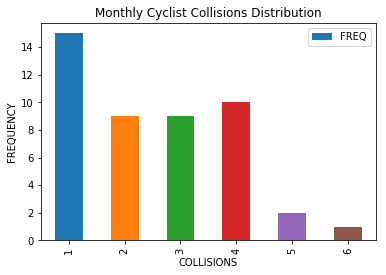

In [34]:
dsts1[dsts1.BIPED == 'B'].plot.bar(x='COUNT', y='FREQ')
plt.title('Monthly Cyclist Collisions Distribution')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')

Text(0.5,0,'COLLISIONS')

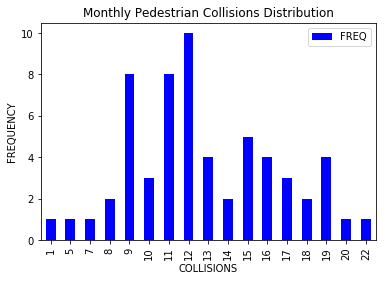

In [35]:
dsts1[dsts1.BIPED == 'P'].plot.bar(x='COUNT', y='FREQ', color='blue')
plt.title('Monthly Pedestrian Collisions Distribution')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')

Text(0.5,0,'COLLISIONS')

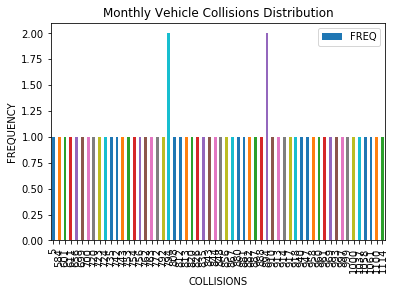

In [36]:
dsts1[dsts1.BIPED == 'M'].plot.bar(x='COUNT', y='FREQ')
plt.title('Monthly Vehicle Collisions Distribution')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')

In [37]:
dsts2 = dsts.groupby(['BIPED']).COUNT.mean().to_frame(name='AVG_COLLISIONS').reset_index()
dsts2

  BIPED  AVG_COLLISIONS
0     B        2.521739
1     M      837.116667
2     P       12.716667

In [38]:
dsts3 = dsts.groupby(['BIPED']).COUNT.std().to_frame(name='STD_COLLISIONS').reset_index()
dsts3

  BIPED  STD_COLLISIONS
0     B        1.378230
1     M      162.976664
2     P        3.940626

### Analysis

In [39]:
df=all_data.groupby(['BIPED','YEAR']).OBJECTID.count().to_frame(name='COUNT').reset_index()
type(df)

pandas.core.frame.DataFrame

In [40]:
df

   BIPED  YEAR  COUNT
0      B  2014     27
1      B  2015     38
2      B  2016     16
3      B  2017     26
4      B  2018      9
5      M  2014   8706
6      M  2015   9740
7      M  2016   9818
8      M  2017  10873
9      M  2018  11090
10     P  2014    163
11     P  2015    171
12     P  2016    129
13     P  2017    145
14     P  2018    155

In [41]:
list(df)

['BIPED', 'YEAR', 'COUNT']

Text(0,0.5,'Collisions')

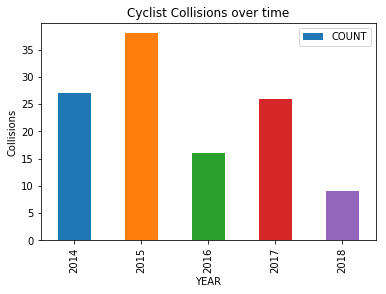

In [42]:
df[df.BIPED == 'B'].plot.bar(x='YEAR', y='COUNT')
plt.title('Cyclist Collisions over time')
plt.ylabel('Collisions')

In [43]:
np.corrcoef(df[df.BIPED == 'B'].YEAR, df[df.BIPED == 'B'].COUNT)[0,1]

-0.6823801608434201

Text(0,0.5,'Collisions')

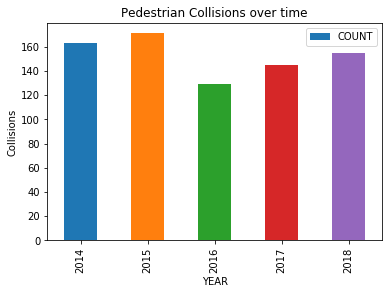

In [44]:
df[df.BIPED == 'P'].plot.bar(x='YEAR', y='COUNT')
plt.title('Pedestrian Collisions over time')
plt.ylabel('Collisions')

In [45]:
np.corrcoef(df[df.BIPED == 'P'].YEAR, df[df.BIPED == 'P'].COUNT)[0,1]

-0.40656162364774223

Text(0,0.5,'Collisions')

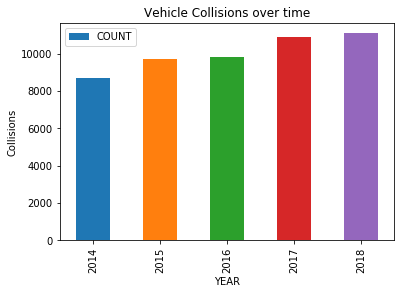

In [46]:
df[df.BIPED == 'M'].plot.bar(x='YEAR', y='COUNT')
plt.title('Vehicle Collisions over time')
plt.ylabel('Collisions')

In [47]:
np.corrcoef(df[df.BIPED == 'M'].YEAR, df[df.BIPED == 'M'].COUNT)[0,1]

0.9681470856838059

In [48]:
df_p = df.pivot(index='BIPED', columns='YEAR')
df_p

      COUNT                          
YEAR   2014  2015  2016   2017   2018
BIPED                                
B        27    38    16     26      9
M      8706  9740  9818  10873  11090
P       163   171   129    145    155

In [49]:
stats.chi2_contingency(df_p)


(42.2777298721486,
 1.2010251494109519e-06,
 8,
 array([[   20.19207138,    22.58216256,    22.61393965,    25.06758502,
            25.54424138],
        [ 8742.99283841,  9777.88171643,  9791.64092279, 10854.04821352,
         11060.43630885],
        [  132.8150902 ,   148.536121  ,   148.74513756,   164.88420146,
           168.01944977]]))

##### Weather

In [50]:
df1=all_data.groupby(['BIPED','WEATHER']).OBJECTID.count().to_frame(name='COUNT').reset_index()
df1

   BIPED                           WEATHER  COUNT
0      B                             CLEAR     96
1      B                            CLOUDY     14
2      B                              RAIN      6
3      M          BLOWING SAND, DIRT, SNOW      6
4      M                             CLEAR  36196
5      M                   CLOUDLY / CLEAR      1
6      M                            CLOUDY   7183
7      M                  FOG, SMOG, SMOKE    116
8      M                             OTHER     48
9      M                              RAIN   5557
..   ...                               ...    ...
13     M  SLEET,HAIL,FREEZING RAIN/DRIZZLE    401
14     M                              SNOW    682
15     M                           UNKNOWN      1
16     P                             CLEAR    584
17     P                            CLOUDY     97
18     P                             OTHER      1
19     P                              RAIN     77
20     P           RAIN/ SEVERE CROSSWINDS      1


Text(0,0.5,'Collisions')

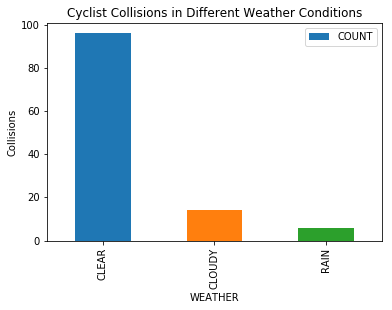

In [51]:
df1[df1.BIPED == 'B'].plot.bar(x='WEATHER', y='COUNT')
plt.title('Cyclist Collisions in Different Weather Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

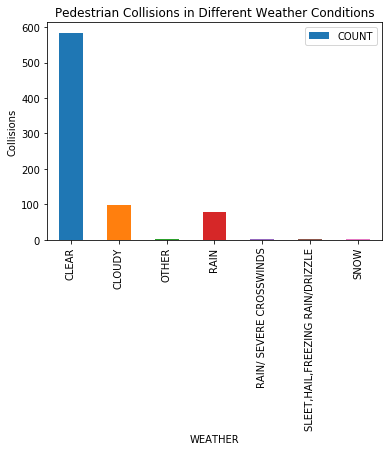

In [52]:
df1[df1.BIPED == 'P'].plot.bar(x='WEATHER', y='COUNT')
plt.title('Pedestrian Collisions in Different Weather Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

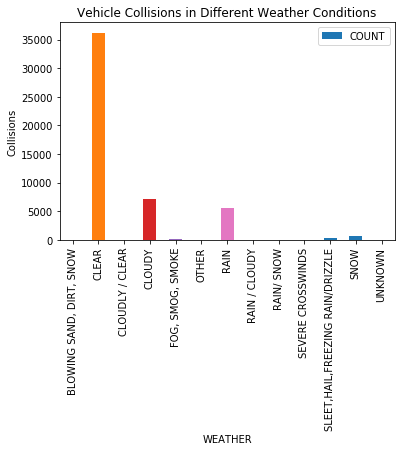

In [53]:
df1[df1.BIPED == 'M'].plot.bar(x='WEATHER', y='COUNT')
plt.title('Vehicle Collisions in Different Weather Conditions')
plt.ylabel('Collisions')

In [54]:
df1_p = df1.pivot(index='BIPED', columns='WEATHER')
df1_p=df1_p.fillna(0)
df1_p

                           COUNT                                   \
WEATHER BLOWING SAND, DIRT, SNOW    CLEAR CLOUDLY / CLEAR  CLOUDY   
BIPED                                                               
B                            0.0     96.0             0.0    14.0   
M                            6.0  36196.0             1.0  7183.0   
P                            0.0    584.0             0.0    97.0   

                                                                              \
WEATHER FOG, SMOG, SMOKE OTHER    RAIN RAIN / CLOUDY RAIN/ SEVERE CROSSWINDS   
BIPED                                                                          
B                    0.0   0.0     6.0           0.0                     0.0   
M                  116.0  48.0  5557.0           6.0                     0.0   
P                    0.0   1.0    77.0           0.0                     1.0   

                                                                              \
WEATHER RAIN/ SNOW SEVER

In [55]:
stats.chi2_contingency(df1_p)

(92.05078530834882,
 2.594703510552193e-09,
 26,
 array([[1.36256852e-02, 8.37434612e+01, 2.27094753e-03, 1.65642913e+01,
         2.63429914e-01, 1.11276429e-01, 1.28081441e+01, 1.36256852e-02,
         2.27094753e-03, 2.27094753e-03, 6.81284260e-03, 9.15191856e-01,
         1.55105717e+00, 2.27094753e-03],
        [5.89675020e+00, 3.62414267e+04, 9.82791699e-01, 7.16848265e+03,
         1.14003837e+02, 4.81567933e+01, 5.54294518e+03, 5.89675020e+00,
         9.82791699e-01, 9.82791699e-01, 2.94837510e+00, 3.96065055e+02,
         6.71246731e+02, 9.82791699e-01],
        [8.96241190e-02, 5.50829836e+02, 1.49373532e-02, 1.08953054e+02,
         1.73273297e+00, 7.31930305e-01, 8.42466719e+01, 8.96241190e-02,
         1.49373532e-02, 1.49373532e-02, 4.48120595e-02, 6.01975333e+00,
         1.02022122e+01, 1.49373532e-02]]))

In [56]:
df11 = df1[df1['WEATHER'].isin(['RAIN', 'CLOUDY', 'CLEAR'])]
df11_p = df11.pivot(index='BIPED', columns='WEATHER')
stats.chi2_contingency(df11_p)

(9.311926207535167,
 0.05375854227400708,
 4,
 array([[8.58786589e+01, 1.69866292e+01, 1.31347119e+01],
        [3.62289487e+04, 7.16601454e+03, 5.54103674e+03],
        [5.61172616e+02, 1.10998836e+02, 8.58285485e+01]]))

##### Light Condition

In [57]:
df2=all_data.groupby(['BIPED','LIGHT_CONDITIONS']).OBJECTID.count().to_frame(name='COUNT').reset_index()
df2

   BIPED            LIGHT_CONDITIONS  COUNT
0      B  DARK - ROADWAY NOT LIGHTED      7
1      B        DARK-LIGHTED ROADWAY     27
2      B                        DAWN      2
3      B                    DAYLIGHT     78
4      B                        DUSK      2
5      M    BLOWING SAND, DIRT, SNOW      1
6      M                      CLOUDY      4
7      M  DARK - ROADWAY NOT LIGHTED   2075
8      M        DARK-LIGHTED ROADWAY  10374
9      M       DARK-UNKNOWN LIGHTING    145
..   ...                         ...    ...
16     M                        SNOW      1
17     M                     UNKNOWN    188
18     P  DARK - ROADWAY NOT LIGHTED     67
19     P        DARK-LIGHTED ROADWAY    251
20     P       DARK-UNKNOWN LIGHTING      6
21     P                        DAWN     11
22     P                    DAYLIGHT    405
23     P                        DUSK     18
24     P                       OTHER      4
25     P                     UNKNOWN      1

[26 rows x 3 columns]

Text(0,0.5,'Collisions')

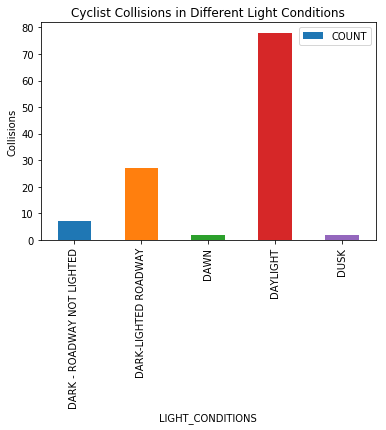

In [58]:
df2[df2.BIPED == 'B'].plot.bar(x='LIGHT_CONDITIONS', y='COUNT')
plt.title('Cyclist Collisions in Different Light Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

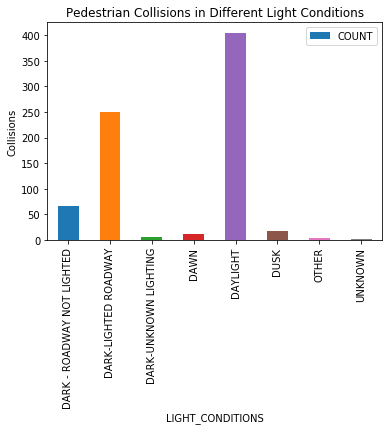

In [59]:
df2[df2.BIPED == 'P'].plot.bar(x='LIGHT_CONDITIONS', y='COUNT')
plt.title('Pedestrian Collisions in Different Light Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

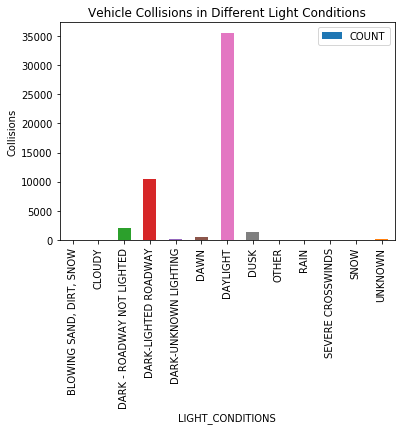

In [60]:
df2[df2.BIPED == 'M'].plot.bar(x='LIGHT_CONDITIONS', y='COUNT')
plt.title('Vehicle Collisions in Different Light Conditions')
plt.ylabel('Collisions')

In [61]:
df2_p = df2.pivot(index='BIPED', columns='LIGHT_CONDITIONS')
df2_p=df2_p.fillna(0)
df1_p

                           COUNT                                   \
WEATHER BLOWING SAND, DIRT, SNOW    CLEAR CLOUDLY / CLEAR  CLOUDY   
BIPED                                                               
B                            0.0     96.0             0.0    14.0   
M                            6.0  36196.0             1.0  7183.0   
P                            0.0    584.0             0.0    97.0   

                                                                              \
WEATHER FOG, SMOG, SMOKE OTHER    RAIN RAIN / CLOUDY RAIN/ SEVERE CROSSWINDS   
BIPED                                                                          
B                    0.0   0.0     6.0           0.0                     0.0   
M                  116.0  48.0  5557.0           6.0                     0.0   
P                    0.0   1.0    77.0           0.0                     1.0   

                                                                              \
WEATHER RAIN/ SNOW SEVER

In [62]:
stats.chi2_contingency(df2_p)

(180.1332072552536,
 6.909477169946608e-26,
 24,
 array([[2.27094753e-03, 9.08379013e-03, 4.88026625e+00, 2.41901331e+01,
         3.42913078e-01, 1.17862177e+00, 8.18176977e+01, 3.09303054e+00,
         4.99608457e-02, 2.27094753e-03, 2.27094753e-03, 2.27094753e-03,
         4.29209084e-01],
        [9.82791699e-01, 3.93116680e+00, 2.11201936e+03, 1.04686972e+04,
         1.48401547e+02, 5.10068892e+02, 3.54080193e+04, 1.33856229e+03,
         2.16214174e+01, 9.82791699e-01, 9.82791699e-01, 9.82791699e-01,
         1.85747631e+02],
        [1.49373532e-02, 5.97494127e-02, 3.21003720e+01, 1.59112686e+02,
         2.25554033e+00, 7.75248630e+00, 5.38162960e+02, 2.03446750e+01,
         3.28621770e-01, 1.49373532e-02, 1.49373532e-02, 1.49373532e-02,
         2.82315975e+00]]))

In [63]:
df21 = df2[df2['LIGHT_CONDITIONS'].isin(['DAYLIGHT', 'DARK-LIGHTED ROADWAY', 'DARK - ROADWAY NOT LIGHTED',
                                        'DAWN', 'DUSK'])]
df21_p = df21.pivot(index='BIPED', columns='LIGHT_CONDITIONS')
stats.chi2_contingency(df21_p)

(130.89902106226356,
 1.841877605332501e-24,
 8,
 array([[4.91587458e+00, 2.43666338e+01, 1.18722146e+00, 8.24146717e+01,
         3.11559850e+00],
        [2.11221570e+03, 1.04696704e+04, 5.10116308e+02, 3.54113109e+04,
         1.33868673e+03],
        [3.18684283e+01, 1.57963005e+02, 7.69647012e+00, 5.34274423e+02,
         2.01976730e+01]]))

##### Traffic Control

In [64]:
df3=all_data.groupby(['BIPED','TRAFFIC_CONTROL']).OBJECTID.count().to_frame(name='COUNT').reset_index()
df3

   BIPED                      TRAFFIC_CONTROL  COUNT
0      B  DOUBLE YELLOW LINE, NO PASSING ZONE      1
1      B          FLASHING STOP AND GO SIGNAL      2
2      B                   NO CONTROL PRESENT     50
3      B                   STOP AND GO SIGNAL     34
4      B                            STOP SIGN     25
5      B                              UNKNOWN      2
6      B                         WARNING SIGN      1
7      B                           YIELD SIGN      1
8      M  DOUBLE YELLOW LINE, NO PASSING ZONE     96
9      M       FLASHING SIGNAL WITH STOP SIGN     54
..   ...                                  ...    ...
24     P  DOUBLE YELLOW LINE, NO PASSING ZONE      1
25     P          FLASHING STOP AND GO SIGNAL      4
26     P                        HUMAN CONTROL      2
27     P                   NO CONTROL PRESENT    537
28     P                                OTHER      3
29     P                   STOP AND GO SIGNAL    144
30     P                            STOP SIGN 

Text(0,0.5,'Collisions')

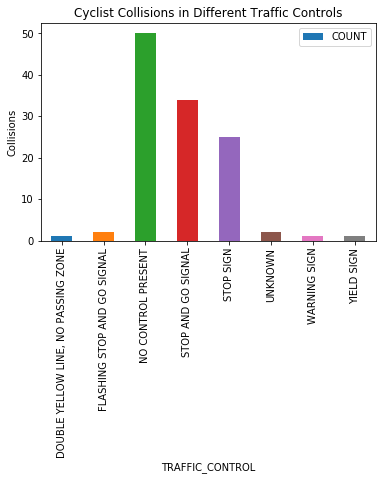

In [65]:
df3[df3.BIPED == 'B'].plot.bar(x='TRAFFIC_CONTROL', y='COUNT')
plt.title('Cyclist Collisions in Different Traffic Controls')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

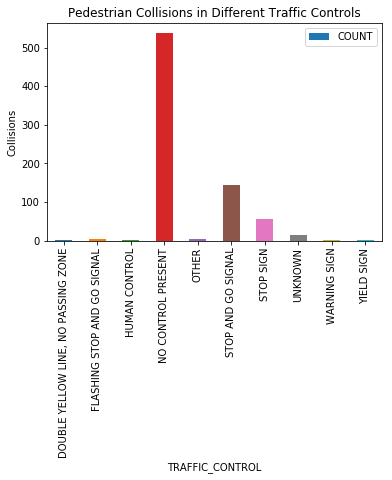

In [66]:
df3[df3.BIPED == 'P'].plot.bar(x='TRAFFIC_CONTROL', y='COUNT')
plt.title('Pedestrian Collisions in Different Traffic Controls')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

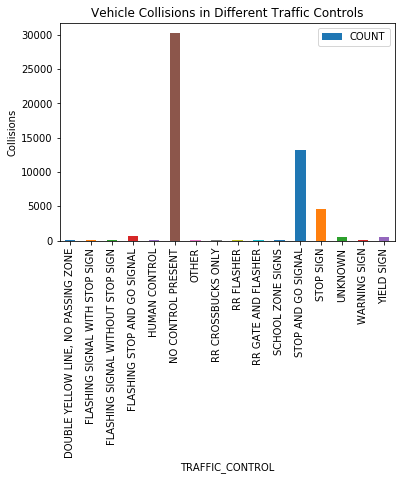

In [67]:
df3[df3.BIPED == 'M'].plot.bar(x='TRAFFIC_CONTROL', y='COUNT')
plt.title('Vehicle Collisions in Different Traffic Controls')
plt.ylabel('Collisions')

In [68]:
df31 = df3[df3['TRAFFIC_CONTROL'].isin(['DOUBLE YELLOW LINE, NO PASSING ZONE', 'FLASHING STOP AND GO SIGNAL', 
                                        'NO CONTROL PRESENT', 'STOP AND GO SIGNAL', 'STOP SIGN', 'UNKNOWN',
                                        'WARNING SIGN', 'YIELD SIGN'])]
df31_p = df31.pivot(index='BIPED', columns='TRAFFIC_CONTROL')
stats.chi2_contingency(df31_p)

(79.69101363974862,
 3.228577457085373e-11,
 14,
 array([[2.23845624e-01, 1.48012208e+00, 7.03560500e+01, 3.05298021e+01,
         1.06806340e+01, 1.20374126e+00, 1.91867677e-01, 1.33393719e+00],
        [9.63153687e+01, 6.36860805e+02, 3.02725101e+04, 1.31362369e+04,
         4.59561902e+03, 5.17940809e+02, 8.25560303e+01, 5.73960973e+02],
        [1.46078567e+00, 9.65907256e+00, 4.59133878e+02, 1.99233278e+02,
         6.97003446e+01, 7.85544944e+00, 1.25210200e+00, 8.70509009e+00]]))

#### Distribution

In [69]:
all_data.OBJECTID.isnull().sum()

0

In [70]:
ds = all_data.groupby(['BIPED','DATE']).DATE.count().to_frame(name='COUNT').reset_index()
ds

     BIPED        DATE  COUNT
0        B  2014-01-20      1
1        B  2014-02-27      1
2        B  2014-05-06      1
3        B  2014-05-11      1
4        B  2014-05-31      1
5        B  2014-06-02      1
6        B  2014-06-10      1
7        B  2014-06-20      3
8        B  2014-06-22      1
9        B  2014-07-03      1
...    ...         ...    ...
2497     P  2018-11-27      1
2498     P  2018-11-28      2
2499     P  2018-11-30      2
2500     P  2018-12-01      1
2501     P  2018-12-02      3
2502     P  2018-12-03      1
2503     P  2018-12-05      1
2504     P  2018-12-13      1
2505     P  2018-12-27      1
2506     P  2018-12-29      1

[2507 rows x 3 columns]

In [71]:
ds_1 = ds.groupby(['BIPED','COUNT']).COUNT.count().to_frame(name='FREQ').reset_index()
ds_1

   BIPED  COUNT  FREQ
0      B      1    99
1      B      2     7
2      B      3     1
3      M      1     5
4      M      6     1
5      M      7     3
6      M      8     5
7      M      9     1
8      M     10     7
9      M     11    13
..   ...    ...   ...
64     M     77     1
65     M     82     1
66     M     87     1
67     M     88     1
68     M     91     1
69     M    116     1
70     P      1   465
71     P      2   108
72     P      3    26
73     P      4     1

[74 rows x 3 columns]

In [72]:
lamB = ds[ds.BIPED=='B'].COUNT.mean()
lamP = ds[ds.BIPED=='P'].COUNT.mean()
lamM = ds[ds.BIPED=='M'].COUNT.mean()

print('Distribution for no. of Vehicle collisions per day is: Poisson(',lamM,')')
print('Distribution for no. of Pedestrian collisions per day is: Poisson(',lamP,')')
print('Distribution for no. of Cyclist collisions per day is: Poisson(',lamB,')')

Distribution for no. of Vehicle collisions per day is: Poisson( 27.90388888888889 )
Distribution for no. of Pedestrian collisions per day is: Poisson( 1.2716666666666667 )
Distribution for no. of Cyclist collisions per day is: Poisson( 1.0841121495327102 )


In [73]:
xP = ds_1[ds_1.BIPED=='P'].COUNT
xB = ds_1[ds_1.BIPED=='B'].COUNT
xM = ds_1[ds_1.BIPED=='M'].COUNT

In [74]:
totP = ds_1[ds_1.BIPED=='P'].FREQ.sum()
totM = ds_1[ds_1.BIPED=='M'].FREQ.sum()
totB = ds_1[ds_1.BIPED=='B'].FREQ.sum()

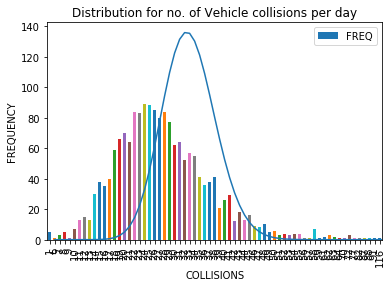

In [75]:
ds_1[ds_1.BIPED == 'M'].plot.bar(x='COUNT', y='FREQ')
plt.title('Distribution for no. of Vehicle collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.plot(xM, poisson.pmf(xM, lamM)*(totM))

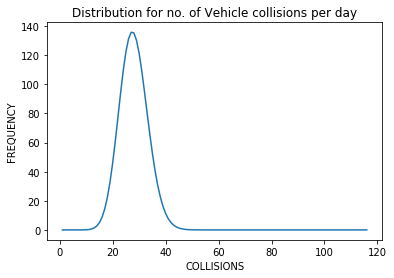

In [76]:
plt.plot(xM, poisson.pmf(xM, lamM)*(totM))
plt.title('Distribution for no. of Vehicle collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.show()

In [77]:
ks_2samp(poisson.pmf(xM, lamM)*(totM), ds_1[ds_1.BIPED == 'M'].FREQ)

Ks_2sampResult(statistic=0.5074626865671642, pvalue=2.777077066188055e-08)

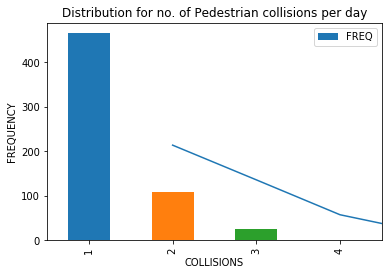

In [78]:
ds_1[ds_1.BIPED == 'P'].plot.bar(x='COUNT', y='FREQ')
plt.title('Distribution for no. of Pedestrian collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.plot(xP, poisson.pmf(xP, lamP)*totP)

In [79]:
ks_2samp(poisson.pmf(xP, lamP)*(totP), ds_1[ds_1.BIPED == 'P'].FREQ)

Ks_2sampResult(statistic=0.25, pvalue=0.9968756885202118)

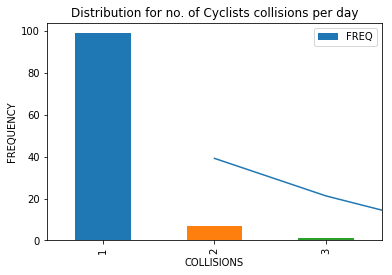

In [80]:
ds_1[ds_1.BIPED == 'B'].plot.bar(x='COUNT', y='FREQ')
plt.title('Distribution for no. of Cyclists collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.plot(xB, poisson.pmf(xB, lamB)*totB)

In [81]:
ks_2samp(poisson.pmf(xM, lamB)*(totB), ds_1[ds_1.BIPED == 'B'].FREQ)

Ks_2sampResult(statistic=0.9850746268656716, pvalue=0.002107694691170252)

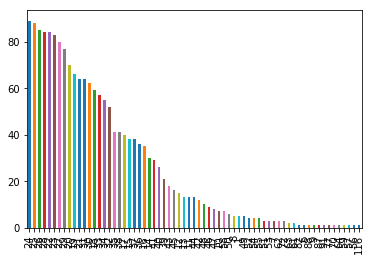

In [82]:
ds[ds.BIPED == 'M']['COUNT'].value_counts().plot(kind='bar')
#plt.show()
#ds['COUNT'].value_counts().plot(kind='bar')

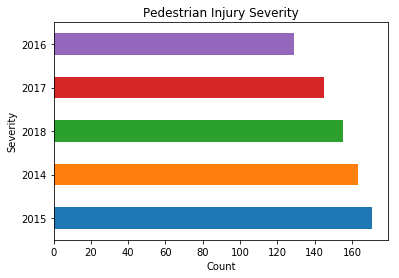

In [83]:
ped_data['YEAR'].value_counts().plot(kind='barh')
plt.title('Pedestrian Injury Severity')
plt.ylabel('Severity')
plt.xlabel('Count')
plt.show()

In [84]:
ped_data.ACCIDENT_YEAR.value_counts()

2015    171
2014    163
2018    155
2017    145
2016    129
Name: ACCIDENT_YEAR, dtype: int64

In [85]:
motor_data.ACCIDENT_YEAR.value_counts()

2018    11091
2017    10873
2016     9817
2015     9740
2014     8706
Name: ACCIDENT_YEAR, dtype: int64

In [86]:
ped_data.SEVERITY.value_counts()

C Type Injury (Possible)             431
B Type Injury (Evident)              166
B Type Injury (Suspected Minor)       55
A Type Injury (Disabling)             42
O No Injury                           18
A Type Injury (Suspected Serious)     16
Name: SEVERITY, dtype: int64

In [87]:
motor_data.SEVERITY.value_counts()

O No Injury                          31312
C Type Injury (Possible)             15503
B Type Injury (Evident)               1807
UNKNOWN                                787
B Type Injury (Suspected Minor)        610
A Type Injury (Disabling)               82
A Type Injury (Suspected Serious)       32
Name: SEVERITY, dtype: int64

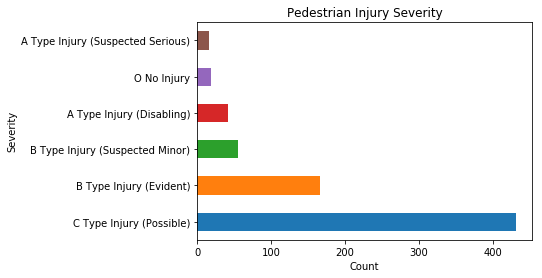

In [88]:
ped_data['SEVERITY'].value_counts().plot(kind='barh')
plt.title('Pedestrian Injury Severity')
plt.ylabel('Severity')
plt.xlabel('Count')
plt.show()

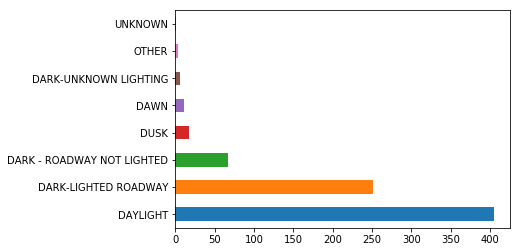

In [89]:
ped_data['LIGHT_CONDITIONS'].value_counts().plot(kind='barh')
plt.show()

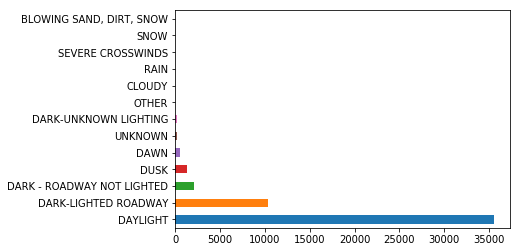

In [90]:
motor_data['LIGHT_CONDITIONS'].value_counts().plot(kind='barh')
plt.show()

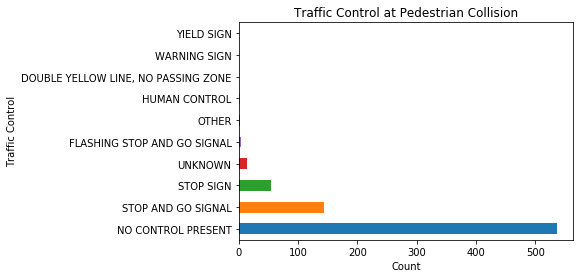

In [91]:
ped_data['TRAFFIC_CONTROL'].value_counts().plot(kind='barh')
plt.title('Traffic Control at Pedestrian Collision')
plt.ylabel('Traffic Control')
plt.xlabel('Count')
plt.show()

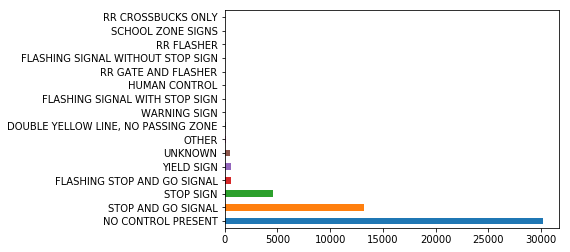

In [92]:
motor_data['TRAFFIC_CONTROL'].value_counts().plot(kind='barh')
plt.show()

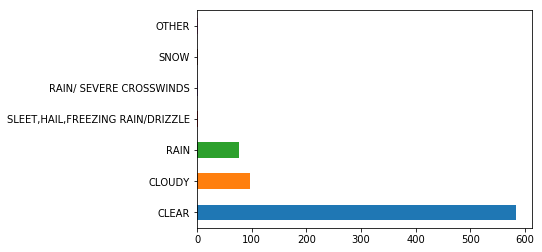

In [93]:
ped_data['WEATHER'].value_counts().plot(kind='barh')
plt.show()

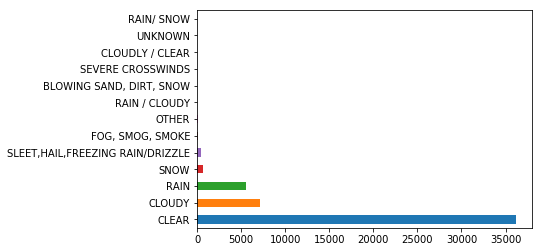

In [94]:
motor_data['WEATHER'].value_counts().plot(kind='barh')
plt.show()

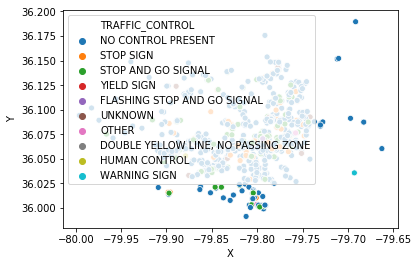

In [95]:
#sns.scatterplot(x="X", y="Y", hue="TRAFFIC_CONTROL", data=ped_data)
sns.scatterplot(x="X", y="Y", hue="TRAFFIC_CONTROL", data=ped_data)
plt.show()